# Portfolio Analyzer
A utility that takes a portfolio as an input with the following calculations 
   * analyzes the current P&L
   * compares with S&P 500
   * YTD Return vs SPY YTD 
   * Total Return vs SP500
   * P&L Total Return SPY
   * Total Cumulative Return over time 
   * Daily Returns, Cumulative Return by Ticker
   * Rolling 21 day return 
   * Sharpe Ratio 
   * Rolling 60 day Beta 
   * Simulated Returns
   * Simulated Cumulative P&L
   
The results are displayed in Dash/Plotly


This project was built by Sumeet Vaidya, Pat Beeson, William Alford and Scott Oziros

In [5]:
# Import initial libraries
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
#import alpaca_trade_api as tradeapi

import dash
import dash_core_components as dcc
import dash_html_components as html
# from dash import html
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import plotly.offline as pyo
import plotly.graph_objs as go
# Set notebook mode to work in offline
pyo.init_notebook_mode(connected=True)
import ipywidgets as widgets
import dash_table
import dash_table.FormatTemplate as FormatTemplate
from dash_table.Format import Format, Scheme, Symbol, Group

from pandas_datareader import data as pdr
import yfinance as yf

from MCForecastTools import MCSimulation

## Inputs : 
The Holdings.xlsx file. This is the basis for all calculations


In [6]:
#Read the Holdings file

portfolio_df = pd.read_excel('Holdings.xlsx', sheet_name='Portfolio', parse_dates=True)
portfolio_df.head(10)

,Acquisition Date,Ticker,Quantity,Unit Cost,Cost Basis,Start of Year
0,2019-02-07,AAPL,300,43.50,13050.00,2020-12-31
1,2019-02-07,JNJ,100,132.50,13250.00,2020-12-31
2,2019-02-07,MCD,100,175.20,17520.00,2020-12-31
3,2019-02-07,MTCH,200,55.80,11160.00,2020-12-31
4,2019-02-07,NFLX,75,345.40,25905.00,2020-12-31
5,2019-02-07,WMT,125,149.35,18668.75,2020-12-31
6,2019-02-07,FB,150,165.50,24825.00,2020-12-31
7,2019-02-07,TWTR,225,30.31,6819.75,2020-12-31
8,2019-02-07,TTD,100,14.30,1430.00,2020-12-31


## Data Sources for Historical data
Alpaca SDK was phased out in favour of Yahoo! Finance as Alpaca SDK did not support Adjusted Closes.
Adjusted Closes are required when there are corporate actions like stock splits.

In [7]:
#Required for Alpaca
# Load .env environment variables
#from dotenv import load_dotenv
#load_dotenv("api.env")

In [8]:
# Set Alpaca API key and secret
#alpaca_api_key = os.getenv("ALPACA_API_KEY")
#alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
#alpaca = tradeapi.REST(
#    alpaca_api_key,
#    alpaca_secret_key,
#    api_version="v2"
#)

## Data Setup to get Real-time Data

In [9]:
# Setup to get real-time data
# Set the tickers and add SPY
portfolio_tickers =portfolio_df['Ticker'].to_list().copy()
tickers = portfolio_df['Ticker'].to_list()
spy_ticker='^GSPC'
tickers.append(spy_ticker)

# Set timeframe to '1D'
#timeframe = "1D"

# Set start and end datetimes 
#start_date = pd.Timestamp("2019-01-01", tz="America/New_York").isoformat()
#end_date = pd.Timestamp("2021-12-31", tz="America/New_York").isoformat()

start_date = "2019-01-01"
end_date = "2021-12-31"
#For YTD Calcs
#end_last_year = datetime.date.fromisoformat(portfolio_df['Start of Year'][0].strftime('%Y-%m-%d'))
#end_last_year = datetime.date.fromisoformat(portfolio_df['Start of Year'][0].strftime('%Y-%m-%d'))
end_last_year=datetime.date.fromisoformat(portfolio_df['Start of Year'][0].strftime('%Y-%m-%d'))

# Set limit_rows to 1000 to retreive the maximum amount of rows
#limit_rows = 1000

# Get 1 year's worth of historical data for Tesla and Coca-Cola
# YOUR CODE HERE!
#df_ticker = alpaca.get_barset(
#    tickers,
#    timeframe,
#    start=start_date,
#    end=end_date,
#    limit=limit_rows
#).df

#Alpaca does not have Adj Closes. Switching to Yahoo! Finance
yf.pdr_override()

df_ticker = pdr.get_data_yahoo(tickers, start=start_date , end=end_date)
# Display data
df_ticker

[*********************100%***********************]  10 of 10 completed


Adj Close                                                  \
                  AAPL          FB         JNJ         MCD        MTCH   
Date                                                                     
2019-01-02   38.326290  135.679993  118.758545  164.881226   42.380001   
2019-01-03   34.508713  131.740005  116.871414  163.794846   41.119999   
2019-01-04   35.981861  137.949997  118.832909  166.960251   43.049999   
2019-01-07   35.901779  138.050003  118.070633  168.777084   43.369999   
2019-01-08   36.586170  142.529999  120.813011  169.132950   44.779999   
...                ...         ...         ...         ...         ...   
2021-11-08  150.440002  338.619995  162.869995  253.100006  155.910004   
2021-11-09  150.809998  335.369995  162.509995  252.649994  155.589996   
2021-11-10  147.919998  327.640015  164.270004  253.130005  154.050003   
2021-11-11  147.869995  327.739990  163.059998  250.160004  149.750000   
2021-11-12  149.990005  340.890015  165.009995  250.669998  146.949997   

                                                                        ...  \
                  NFLX         TTD       TWTR         WMT        ^GSPC  ...   
Date                                                                    ...   
2019-01-02  267.660004   11.616000  28.809999   88.933044  2510.030029  ...   
2019-01-03  271.200012   10.956000  27.990000   88.475731  2447.889893  ...   
2019-01-04  297.570007   11.792000  29.950001   89.028336  2531.939941  ...   
2019-01-07  315.339996   12.457000  31.340000   90.076393  2549.689941  ...   
2019-01-08  320.269989   12.805000  31.799999   90.705238  2574.409912  ...   
...                ...         ...        ...         ...          ...  ...   
2021-11-08  651.450012   88.750000  54.080002  149.270004  4701.700195  ...   
2021-11-09  655.989990   97.089996  53.700001  149.789993  4685.250000  ...   
2021-11-10  646.909973   88.660004  52.330002  148.440002  4646.709961  ...   
2021-11-11  657.580017   91.550003  51.980000  148.500000  4649.270020  ...   
2021-11-12  682.609985  100.330002  52.250000  147.759995  4682.850098  ...   

               Volume                                                  \
                 AAPL        FB       JNJ      MCD     MTCH      NFLX   
Date                                                                    
2019-01-02  148158800  28146200   7631700  2571500  1677800  11679500   
2019-01-03  365248800  22717900   8654500  3728200  1828000  14969600   
2019-01-04  234428400  29002100   8831700  3194300  2460100  19330100   
2019-01-07  219111200  20089300   8404700  3283000  1471900  18620100   
2019-01-08  164101200  26263800   9351600  2941400  2470500  15359200   
...               ...       ...       ...      ...      ...       ...   
2021-11-08   55020900  18342500   5578800  2471300  2920600   2887500   
2021-11-09   56787900  17556700   6112800  2258900  2134300   2415600   
2021-11-10   65187100  21872600   6225100  1794300  2040300   2405800   
2021-11-11   41000000  12376600   4118800  1640500  2116200   2868300   
2021-11-12   63632600  25387200  18982100  1625200  3650000   4192700   

                                                     
                 TTD      TWTR      WMT       ^GSPC  
Date                                                 
2019-01-02   8393000  15053700  8152700  3733160000  
2019-01-03   7754000  19051700  8277300  3822860000  
2019-01-04  11460000  23412600  8029100  4213410000  
2019-01-07  10790000  19917800  7789700  4104710000  
2019-01-08   9501000  18915200  7200900  4083030000  
...              ...       ...      ...         ...  
2021-11-08  31558100  10565500  5124400  3465720000  
2021-11-09  17242200  11230100  5000600  3110230000  
2021-11-10  10017900  18858400  5601200  3581630000  
2021-11-11   3865800  13972100  4534400  2623140000  
2021-11-12  12297800  13283300  6100800  2865790000  

[724 rows x 60 columns]

In [10]:
df_ticker.dtypes

Adj Close  AAPL     float64
           FB       float64
           JNJ      float64
           MCD      float64
           MTCH     float64
           NFLX     float64
           TTD      float64
           TWTR     float64
           WMT      float64
           ^GSPC    float64
Close      AAPL     float64
           FB       float64
           JNJ      float64
           MCD      float64
           MTCH     float64
           NFLX     float64
           TTD      float64
           TWTR     float64
           WMT      float64
           ^GSPC    float64
High       AAPL     float64
           FB       float64
           JNJ      float64
           MCD      float64
           MTCH     float64
           NFLX     float64
           TTD      float64
           TWTR     float64
           WMT      float64
           ^GSPC    float64
Low        AAPL     float64
           FB       float64
           JNJ      float64
           MCD      float64
           MTCH     float64
           NFLX     

In [11]:
#verify the dataframe has correct data
df_ticker.tail()

Adj Close                                                  \
                  AAPL          FB         JNJ         MCD        MTCH   
Date                                                                     
2021-11-08  150.440002  338.619995  162.869995  253.100006  155.910004   
2021-11-09  150.809998  335.369995  162.509995  252.649994  155.589996   
2021-11-10  147.919998  327.640015  164.270004  253.130005  154.050003   
2021-11-11  147.869995  327.739990  163.059998  250.160004  149.750000   
2021-11-12  149.990005  340.890015  165.009995  250.669998  146.949997   

                                                                        ...  \
                  NFLX         TTD       TWTR         WMT        ^GSPC  ...   
Date                                                                    ...   
2021-11-08  651.450012   88.750000  54.080002  149.270004  4701.700195  ...   
2021-11-09  655.989990   97.089996  53.700001  149.789993  4685.250000  ...   
2021-11-10  646.909973   88.660004  52.330002  148.440002  4646.709961  ...   
2021-11-11  657.580017   91.550003  51.980000  148.500000  4649.270020  ...   
2021-11-12  682.609985  100.330002  52.250000  147.759995  4682.850098  ...   

              Volume                                                           \
                AAPL        FB       JNJ      MCD     MTCH     NFLX       TTD   
Date                                                                            
2021-11-08  55020900  18342500   5578800  2471300  2920600  2887500  31558100   
2021-11-09  56787900  17556700   6112800  2258900  2134300  2415600  17242200   
2021-11-10  65187100  21872600   6225100  1794300  2040300  2405800  10017900   
2021-11-11  41000000  12376600   4118800  1640500  2116200  2868300   3865800   
2021-11-12  63632600  25387200  18982100  1625200  3650000  4192700  12297800   

                                           
                TWTR      WMT       ^GSPC  
Date                                       
2021-11-08  10565500  5124400  3465720000  
2021-11-09  11230100  5000600  3110230000  
2021-11-10  18858400  5601200  3581630000  
2021-11-11  13972100  4534400  2623140000  
2021-11-12  13283300  6100800  2865790000  

[5 rows x 60 columns]

### Get Closing Prices using the Adj Close from the dataset

In [12]:
# Create and empty DataFrame for closing prices

df_closing_prices = pd.DataFrame()
for ticker in tickers:
    df_closing_prices[ticker]=df_ticker['Adj Close'][ticker]
    
# Drop the time component of the date
df_closing_prices.index = df_closing_prices.index.date
df_closing_prices.index.name='Date'
df_closing_prices.tail()    

,AAPL,JNJ,MCD,MTCH,NFLX,WMT,FB,TWTR,TTD,^GSPC
Date,,,,,,,,,,
2021-11-08,150.440002,162.869995,253.100006,155.910004,651.450012,149.270004,338.619995,54.080002,88.750000,4701.700195
2021-11-09,150.809998,162.509995,252.649994,155.589996,655.989990,149.789993,335.369995,53.700001,97.089996,4685.250000
2021-11-10,147.919998,164.270004,253.130005,154.050003,646.909973,148.440002,327.640015,52.330002,88.660004,4646.709961
2021-11-11,147.869995,163.059998,250.160004,149.750000,657.580017,148.500000,327.739990,51.980000,91.550003,4649.270020
2021-11-12,149.990005,165.009995,250.669998,146.949997,682.609985,147.759995,340.890015,52.250000,100.330002,4682.850098


In [13]:
#print the dataframe for closing prices
df_closing_prices

,AAPL,JNJ,MCD,MTCH,NFLX,WMT,FB,TWTR,TTD,^GSPC
Date,,,,,,,,,,
2019-01-02,38.326290,118.758545,164.881226,42.380001,267.660004,88.933044,135.679993,28.809999,11.616000,2510.030029
2019-01-03,34.508713,116.871414,163.794846,41.119999,271.200012,88.475731,131.740005,27.990000,10.956000,2447.889893
2019-01-04,35.981861,118.832909,166.960251,43.049999,297.570007,89.028336,137.949997,29.950001,11.792000,2531.939941
2019-01-07,35.901779,118.070633,168.777084,43.369999,315.339996,90.076393,138.050003,31.340000,12.457000,2549.689941
2019-01-08,36.586170,120.813011,169.132950,44.779999,320.269989,90.705238,142.529999,31.799999,12.805000,2574.409912
...,...,...,...,...,...,...,...,...,...,...
2021-11-08,150.440002,162.869995,253.100006,155.910004,651.450012,149.270004,338.619995,54.080002,88.750000,4701.700195
2021-11-09,150.809998,162.509995,252.649994,155.589996,655.989990,149.789993,335.369995,53.700001,97.089996,4685.250000
2021-11-10,147.919998,164.270004,253.130005,154.050003,646.909973,148.440002,327.640015,52.330002,88.660004,4646.709961


In [14]:
portfolio_df

,Acquisition Date,Ticker,Quantity,Unit Cost,Cost Basis,Start of Year
0,2019-02-07,AAPL,300,43.50,13050.00,2020-12-31
1,2019-02-07,JNJ,100,132.50,13250.00,2020-12-31
2,2019-02-07,MCD,100,175.20,17520.00,2020-12-31
3,2019-02-07,MTCH,200,55.80,11160.00,2020-12-31
4,2019-02-07,NFLX,75,345.40,25905.00,2020-12-31
5,2019-02-07,WMT,125,149.35,18668.75,2020-12-31
6,2019-02-07,FB,150,165.50,24825.00,2020-12-31
7,2019-02-07,TWTR,225,30.31,6819.75,2020-12-31
8,2019-02-07,TTD,100,14.30,1430.00,2020-12-31


In [15]:
# Grab the latest stock close price by using the last line in the dataframe

df_close_latest = df_closing_prices.iloc[-1].to_frame('Last Close')
df_close_latest.index.name='Ticker'
df_close_latest

,Last Close
Ticker,
AAPL,149.990005
JNJ,165.009995
MCD,250.669998
MTCH,146.949997
NFLX,682.609985
WMT,147.759995
FB,340.890015
TWTR,52.250000
TTD,100.330002


In [16]:
#get the End of Last year Closing price using the information from the Holdings file.
#the code should be enhanced to use the last date of the prior year
df_close_YTD_start = df_closing_prices.loc[end_last_year].to_frame('YTD Close')
df_close_YTD_start.index.name="Ticker"
df_close_YTD_start

,YTD Close
Ticker,
AAPL,131.876999
JNJ,154.516754
MCD,210.939972
MTCH,151.190002
NFLX,540.729980
WMT,142.464844
FB,273.160004
TWTR,54.150002
TTD,80.099998


In [17]:
#Switch the portfolio dataframe to using the Ticker as an index
portfolio_df.set_index(['Ticker'], inplace=True)

portfolio_df.head()

,Acquisition Date,Quantity,Unit Cost,Cost Basis,Start of Year
Ticker,,,,,
AAPL,2019-02-07,300,43.5,13050.0,2020-12-31
JNJ,2019-02-07,100,132.5,13250.0,2020-12-31
MCD,2019-02-07,100,175.2,17520.0,2020-12-31
MTCH,2019-02-07,200,55.8,11160.0,2020-12-31
NFLX,2019-02-07,75,345.4,25905.0,2020-12-31


In [18]:
#Transpose the portfolio df to get info by Ticker
df_T = portfolio_df.T.copy()

In [19]:
#Verify the quantity of one stock
df_T['AAPL']['Quantity']

300

In [20]:
df_portfolio_value = df_closing_prices.copy()
for ticker in portfolio_tickers:
    df_portfolio_value[ticker]=df_portfolio_value[ticker] * df_T[ticker]['Quantity']
    
df_portfolio_value = df_portfolio_value.drop(columns='^GSPC')

In [21]:
# Merge the portfolio dataframe with the  close dataframe; they are being joined by their indexes.

merged_portfolio = pd.merge(portfolio_df, df_close_latest, left_index=True, right_index=True)
merged_portfolio.index.name="Ticker"
merged_portfolio.head(10)

,Acquisition Date,Quantity,Unit Cost,Cost Basis,Start of Year,Last Close
Ticker,,,,,,
AAPL,2019-02-07,300,43.50,13050.00,2020-12-31,149.990005
JNJ,2019-02-07,100,132.50,13250.00,2020-12-31,165.009995
MCD,2019-02-07,100,175.20,17520.00,2020-12-31,250.669998
MTCH,2019-02-07,200,55.80,11160.00,2020-12-31,146.949997
NFLX,2019-02-07,75,345.40,25905.00,2020-12-31,682.609985
WMT,2019-02-07,125,149.35,18668.75,2020-12-31,147.759995
FB,2019-02-07,150,165.50,24825.00,2020-12-31,340.890015
TWTR,2019-02-07,225,30.31,6819.75,2020-12-31,52.250000
TTD,2019-02-07,100,14.30,1430.00,2020-12-31,100.330002


In [22]:
# The below creates a new column which is the ticker return; takes the latest adjusted close for each position
# and divides that by the initial share cost.

merged_portfolio['Ticker Return'] = merged_portfolio['Last Close'] / merged_portfolio['Unit Cost'] - 1
merged_portfolio


,Acquisition Date,Quantity,Unit Cost,Cost Basis,Start of Year,Last Close,Ticker Return
Ticker,,,,,,,
AAPL,2019-02-07,300,43.50,13050.00,2020-12-31,149.990005,2.448046
JNJ,2019-02-07,100,132.50,13250.00,2020-12-31,165.009995,0.245358
MCD,2019-02-07,100,175.20,17520.00,2020-12-31,250.669998,0.430765
MTCH,2019-02-07,200,55.80,11160.00,2020-12-31,146.949997,1.633512
NFLX,2019-02-07,75,345.40,25905.00,2020-12-31,682.609985,0.976288
WMT,2019-02-07,125,149.35,18668.75,2020-12-31,147.759995,-0.010646
FB,2019-02-07,150,165.50,24825.00,2020-12-31,340.890015,1.059758
TWTR,2019-02-07,225,30.31,6819.75,2020-12-31,52.250000,0.723854
TTD,2019-02-07,100,14.30,1430.00,2020-12-31,100.330002,6.016084


In [23]:
#Get S&P Closes and index by date
df_spy_closing_prices=df_closing_prices['^GSPC'].to_frame('SPY Closes')
df_spy_closing_prices.index = df_spy_closing_prices.index.astype('datetime64[ns]')
df_spy_closing_prices.index.name='Date'
df_spy_closing_prices

,SPY Closes
Date,
2019-01-02,2510.030029
2019-01-03,2447.889893
2019-01-04,2531.939941
2019-01-07,2549.689941
2019-01-08,2574.409912
...,...
2021-11-08,4701.700195
2021-11-09,4685.250000
2021-11-10,4646.709961


### Compute the Current PNL, and compare with S&P 500

In [24]:
# Here we are merging the new dataframe with the sp500 adjusted closes since the sp start price based on 
# each ticker's acquisition date and sp500 close date.

merged_portfolio_sp = pd.merge(merged_portfolio, df_spy_closing_prices, left_on='Acquisition Date', right_index=True)
merged_portfolio_sp.head()

,Acquisition Date,Quantity,Unit Cost,Cost Basis,Start of Year,Last Close,Ticker Return,SPY Closes
Ticker,,,,,,,,
AAPL,2019-02-07,300,43.5,13050.0,2020-12-31,149.990005,2.448046,2706.050049
JNJ,2019-02-07,100,132.5,13250.0,2020-12-31,165.009995,0.245358,2706.050049
MCD,2019-02-07,100,175.2,17520.0,2020-12-31,250.669998,0.430765,2706.050049
MTCH,2019-02-07,200,55.8,11160.0,2020-12-31,146.949997,1.633512,2706.050049
NFLX,2019-02-07,75,345.4,25905.0,2020-12-31,682.609985,0.976288,2706.050049


In [25]:
# This new column determines what SP 500 equivalent purchase would have been at purchase date of stock.
merged_portfolio_sp['Equiv SPY Shares'] = merged_portfolio_sp['Cost Basis'] / merged_portfolio_sp['SPY Closes']
merged_portfolio_sp.head()

,Acquisition Date,Quantity,Unit Cost,Cost Basis,Start of Year,Last Close,Ticker Return,SPY Closes,Equiv SPY Shares
Ticker,,,,,,,,,
AAPL,2019-02-07,300,43.5,13050.0,2020-12-31,149.990005,2.448046,2706.050049,4.822527
JNJ,2019-02-07,100,132.5,13250.0,2020-12-31,165.009995,0.245358,2706.050049,4.896436
MCD,2019-02-07,100,175.2,17520.0,2020-12-31,250.669998,0.430765,2706.050049,6.474381
MTCH,2019-02-07,200,55.8,11160.0,2020-12-31,146.949997,1.633512,2706.050049,4.124092
NFLX,2019-02-07,75,345.4,25905.0,2020-12-31,682.609985,0.976288,2706.050049,9.572994


In [26]:
df_close_latest.loc['^GSPC']

Last Close    4682.850098
Name: ^GSPC, dtype: float64

In [27]:
df_closing_prices.iloc[-1]['^GSPC']

4682.85009765625

In [28]:
# We are joining the developing dataframe with the sp500 closes again, this time with the latest close for SP.
merged_portfolio_sp['SPY Latest Close'] =  df_closing_prices.iloc[-1]['^GSPC']

merged_portfolio_sp.head()

,Acquisition Date,Quantity,Unit Cost,Cost Basis,Start of Year,Last Close,Ticker Return,SPY Closes,Equiv SPY Shares,SPY Latest Close
Ticker,,,,,,,,,,
AAPL,2019-02-07,300,43.5,13050.0,2020-12-31,149.990005,2.448046,2706.050049,4.822527,4682.850098
JNJ,2019-02-07,100,132.5,13250.0,2020-12-31,165.009995,0.245358,2706.050049,4.896436,4682.850098
MCD,2019-02-07,100,175.2,17520.0,2020-12-31,250.669998,0.430765,2706.050049,6.474381,4682.850098
MTCH,2019-02-07,200,55.8,11160.0,2020-12-31,146.949997,1.633512,2706.050049,4.124092,4682.850098
NFLX,2019-02-07,75,345.4,25905.0,2020-12-31,682.609985,0.976288,2706.050049,9.572994,4682.850098


In [29]:
# Percent return of SP from acquisition date of position through latest trading day.
merged_portfolio_sp['SP Return'] = merged_portfolio_sp['SPY Latest Close'] / merged_portfolio_sp['SPY Closes'] - 1

# This is a new column which takes the tickers return and subtracts the sp 500 equivalent range return.
merged_portfolio_sp['Abs. Return Compare'] = merged_portfolio_sp['Ticker Return'] - merged_portfolio_sp['SP Return']

# This is a new column where we calculate the ticker's share value by multiplying the original quantity by the latest close.
merged_portfolio_sp['Ticker Share Value'] = merged_portfolio_sp['Quantity'] * merged_portfolio_sp['Last Close']

# We calculate the equivalent SP 500 Value if we take the original SP shares * the latest SP 500 share price.
merged_portfolio_sp['SPY Value'] = merged_portfolio_sp['Equiv SPY Shares'] * merged_portfolio_sp['SPY Latest Close']

# This is a new column where we take the current market value for the shares and subtract the SP 500 value.
merged_portfolio_sp['Abs Value Compare'] = merged_portfolio_sp['Ticker Share Value'] - merged_portfolio_sp['SPY Value']

# This column calculates profit / loss for stock position.
merged_portfolio_sp['Stock Gain / (Loss)'] = merged_portfolio_sp['Ticker Share Value'] - merged_portfolio_sp['Cost Basis']

# This column calculates profit / loss for SP 500.
merged_portfolio_sp['SPY Gain / (Loss)'] = merged_portfolio_sp['SPY Value'] - merged_portfolio_sp['Cost Basis']

merged_portfolio_sp.head()

,Acquisition Date,Quantity,Unit Cost,Cost Basis,Start of Year,Last Close,Ticker Return,SPY Closes,Equiv SPY Shares,SPY Latest Close,SP Return,Abs. Return Compare,Ticker Share Value,SPY Value,Abs Value Compare,Stock Gain / (Loss),SPY Gain / (Loss)
Ticker,,,,,,,,,,,,,,,,,
AAPL,2019-02-07,300,43.5,13050.0,2020-12-31,149.990005,2.448046,2706.050049,4.822527,4682.850098,0.730511,1.717535,44997.001648,22583.172030,22413.829618,31947.001648,9533.172030
JNJ,2019-02-07,100,132.5,13250.0,2020-12-31,165.009995,0.245358,2706.050049,4.896436,4682.850098,0.730511,-0.485153,16500.999451,22929.274283,-6428.274833,3250.999451,9679.274283
MCD,2019-02-07,100,175.2,17520.0,2020-12-31,250.669998,0.430765,2706.050049,6.474381,4682.850098,0.730511,-0.299746,25066.999817,30318.557392,-5251.557575,7546.999817,12798.557392
MTCH,2019-02-07,200,55.8,11160.0,2020-12-31,146.949997,1.633512,2706.050049,4.124092,4682.850098,0.730511,0.903001,29389.999390,19312.505736,10077.493654,18229.999390,8152.505736
NFLX,2019-02-07,75,345.4,25905.0,2020-12-31,682.609985,0.976288,2706.050049,9.572994,4682.850098,0.730511,0.245777,51195.748901,44828.894363,6366.854538,25290.748901,18923.894363


In [30]:
# Merge the overall dataframe with the adj close start of year dataframe for YTD tracking of tickers.
# Should not need to do the outer join;

merged_portfolio_sp_YTD = pd.merge(merged_portfolio_sp, df_close_YTD_start, left_index=True, right_index=True)
# , how='outer'
#merged_portfolio_sp_YTD.rename(columns={'2020-12-31 00:00:00-05:00':'SPY YTD Start Close'}, inplace=True)
merged_portfolio_sp_YTD.head()

,Acquisition Date,Quantity,Unit Cost,Cost Basis,Start of Year,Last Close,Ticker Return,SPY Closes,Equiv SPY Shares,SPY Latest Close,SP Return,Abs. Return Compare,Ticker Share Value,SPY Value,Abs Value Compare,Stock Gain / (Loss),SPY Gain / (Loss),YTD Close
Ticker,,,,,,,,,,,,,,,,,,
AAPL,2019-02-07,300,43.5,13050.0,2020-12-31,149.990005,2.448046,2706.050049,4.822527,4682.850098,0.730511,1.717535,44997.001648,22583.172030,22413.829618,31947.001648,9533.172030,131.876999
JNJ,2019-02-07,100,132.5,13250.0,2020-12-31,165.009995,0.245358,2706.050049,4.896436,4682.850098,0.730511,-0.485153,16500.999451,22929.274283,-6428.274833,3250.999451,9679.274283,154.516754
MCD,2019-02-07,100,175.2,17520.0,2020-12-31,250.669998,0.430765,2706.050049,6.474381,4682.850098,0.730511,-0.299746,25066.999817,30318.557392,-5251.557575,7546.999817,12798.557392,210.939972
MTCH,2019-02-07,200,55.8,11160.0,2020-12-31,146.949997,1.633512,2706.050049,4.124092,4682.850098,0.730511,0.903001,29389.999390,19312.505736,10077.493654,18229.999390,8152.505736,151.190002
NFLX,2019-02-07,75,345.4,25905.0,2020-12-31,682.609985,0.976288,2706.050049,9.572994,4682.850098,0.730511,0.245777,51195.748901,44828.894363,6366.854538,25290.748901,18923.894363,540.729980


In [31]:
merged_portfolio_sp_YTD.dtypes

Acquisition Date       datetime64[ns]
Quantity                        int64
Unit Cost                     float64
Cost Basis                    float64
Start of Year          datetime64[ns]
Last Close                    float64
Ticker Return                 float64
SPY Closes                    float64
Equiv SPY Shares              float64
SPY Latest Close              float64
SP Return                     float64
Abs. Return Compare           float64
Ticker Share Value            float64
SPY Value                     float64
Abs Value Compare             float64
Stock Gain / (Loss)           float64
SPY Gain / (Loss)             float64
YTD Close                     float64
dtype: object

#### Compute YTD Statistics

In [32]:
# We are joining the developing dataframe with the sp500 closes again, this time with the latest close for SP.
merged_portfolio_sp_YTD['SPY YTD Close'] =  df_closing_prices.loc[end_last_year]['^GSPC']

merged_portfolio_sp_YTD.head()

,Acquisition Date,Quantity,Unit Cost,Cost Basis,Start of Year,Last Close,Ticker Return,SPY Closes,Equiv SPY Shares,SPY Latest Close,SP Return,Abs. Return Compare,Ticker Share Value,SPY Value,Abs Value Compare,Stock Gain / (Loss),SPY Gain / (Loss),YTD Close,SPY YTD Close
Ticker,,,,,,,,,,,,,,,,,,,
AAPL,2019-02-07,300,43.5,13050.0,2020-12-31,149.990005,2.448046,2706.050049,4.822527,4682.850098,0.730511,1.717535,44997.001648,22583.172030,22413.829618,31947.001648,9533.172030,131.876999,3756.070068
JNJ,2019-02-07,100,132.5,13250.0,2020-12-31,165.009995,0.245358,2706.050049,4.896436,4682.850098,0.730511,-0.485153,16500.999451,22929.274283,-6428.274833,3250.999451,9679.274283,154.516754,3756.070068
MCD,2019-02-07,100,175.2,17520.0,2020-12-31,250.669998,0.430765,2706.050049,6.474381,4682.850098,0.730511,-0.299746,25066.999817,30318.557392,-5251.557575,7546.999817,12798.557392,210.939972,3756.070068
MTCH,2019-02-07,200,55.8,11160.0,2020-12-31,146.949997,1.633512,2706.050049,4.124092,4682.850098,0.730511,0.903001,29389.999390,19312.505736,10077.493654,18229.999390,8152.505736,151.190002,3756.070068
NFLX,2019-02-07,75,345.4,25905.0,2020-12-31,682.609985,0.976288,2706.050049,9.572994,4682.850098,0.730511,0.245777,51195.748901,44828.894363,6366.854538,25290.748901,18923.894363,540.729980,3756.070068


In [33]:
merged_portfolio_sp_YTD.dtypes

Acquisition Date       datetime64[ns]
Quantity                        int64
Unit Cost                     float64
Cost Basis                    float64
Start of Year          datetime64[ns]
Last Close                    float64
Ticker Return                 float64
SPY Closes                    float64
Equiv SPY Shares              float64
SPY Latest Close              float64
SP Return                     float64
Abs. Return Compare           float64
Ticker Share Value            float64
SPY Value                     float64
Abs Value Compare             float64
Stock Gain / (Loss)           float64
SPY Gain / (Loss)             float64
YTD Close                     float64
SPY YTD Close                 float64
dtype: object

In [34]:
# YTD return for portfolio position.
merged_portfolio_sp_YTD['Share YTD'] = merged_portfolio_sp_YTD['Last Close'] / merged_portfolio_sp_YTD['YTD Close'] - 1

# YTD return for SP to run compares.
merged_portfolio_sp_YTD['SPY YTD'] = merged_portfolio_sp_YTD['SPY Latest Close'] / merged_portfolio_sp_YTD['SPY YTD Close'] - 1



In [35]:
# Cumulative sum of original investment
merged_portfolio_sp_YTD['Cum Invst'] = merged_portfolio_sp_YTD['Cost Basis'].cumsum()

# Cumulative sum of Ticker Share Value (latest FMV based on initial quantity purchased).
merged_portfolio_sp_YTD['Cum Ticker Returns'] = merged_portfolio_sp_YTD['Ticker Share Value'].cumsum()

# Cumulative sum of SP Share Value (latest FMV driven off of initial SP equiv purchase).
merged_portfolio_sp_YTD['Cum SP Returns'] = merged_portfolio_sp_YTD['SPY Value'].cumsum()

# Cumulative CoC multiple return for stock investments
merged_portfolio_sp_YTD['Cum Ticker ROI Mult'] = merged_portfolio_sp_YTD['Cum Ticker Returns'] / merged_portfolio_sp_YTD['Cum Invst']

merged_portfolio_sp_YTD.head()


,Acquisition Date,Quantity,Unit Cost,Cost Basis,Start of Year,Last Close,Ticker Return,SPY Closes,Equiv SPY Shares,SPY Latest Close,...,Stock Gain / (Loss),SPY Gain / (Loss),YTD Close,SPY YTD Close,Share YTD,SPY YTD,Cum Invst,Cum Ticker Returns,Cum SP Returns,Cum Ticker ROI Mult
Ticker,,,,,,,,,,,,,,,,,,,,,
AAPL,2019-02-07,300,43.5,13050.0,2020-12-31,149.990005,2.448046,2706.050049,4.822527,4682.850098,...,31947.001648,9533.172030,131.876999,3756.070068,0.137348,0.246742,13050.0,44997.001648,22583.172030,3.448046
JNJ,2019-02-07,100,132.5,13250.0,2020-12-31,165.009995,0.245358,2706.050049,4.896436,4682.850098,...,3250.999451,9679.274283,154.516754,3756.070068,0.067910,0.246742,26300.0,61498.001099,45512.446313,2.338327
MCD,2019-02-07,100,175.2,17520.0,2020-12-31,250.669998,0.430765,2706.050049,6.474381,4682.850098,...,7546.999817,12798.557392,210.939972,3756.070068,0.188348,0.246742,43820.0,86565.000916,75831.003705,1.975468
MTCH,2019-02-07,200,55.8,11160.0,2020-12-31,146.949997,1.633512,2706.050049,4.124092,4682.850098,...,18229.999390,8152.505736,151.190002,3756.070068,-0.028044,0.246742,54980.0,115955.000305,95143.509441,2.109040
NFLX,2019-02-07,75,345.4,25905.0,2020-12-31,682.609985,0.976288,2706.050049,9.572994,4682.850098,...,25290.748901,18923.894363,540.729980,3756.070068,0.262386,0.246742,80885.0,167150.749207,139972.403804,2.066523


In [36]:
merged_portfolio_sp_YTD['Current Value'] = merged_portfolio_sp_YTD['Last Close'] * merged_portfolio_sp_YTD['Quantity']
merged_portfolio_sp_YTD['Pct Change'] = merged_portfolio_sp_YTD['Current Value'] / merged_portfolio_sp_YTD['Cost Basis']

# Calculate Daily Returns

In [37]:
#Daily Returns
df_daily_returns = pd.DataFrame()
for ticker in portfolio_tickers:
    df_daily_returns[ticker] = df_closing_prices[ticker].pct_change()
    
df_daily_returns.head()


,AAPL,JNJ,MCD,MTCH,NFLX,WMT,FB,TWTR,TTD
Date,,,,,,,,,
2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,-0.099607,-0.015890,-0.006589,-0.029731,0.013226,-0.005142,-0.029039,-0.028462,-0.056818
2019-01-04,0.042689,0.016783,0.019325,0.046936,0.097234,0.006246,0.047138,0.070025,0.076305
2019-01-07,-0.002226,-0.006415,0.010882,0.007433,0.059717,0.011772,0.000725,0.046411,0.056394
2019-01-08,0.019063,0.023227,0.002108,0.032511,0.015634,0.006981,0.032452,0.014678,0.027936


# Calculate Cumulative Daily Returns

In [38]:
# Calculate and plot the cumulative returns of the 4 fund portfolios 
cum_daily_returns_df = (1 + df_daily_returns).cumprod() - 1
cum_daily_returns_df.dropna(inplace=True)
cum_daily_returns_df.head()

,AAPL,JNJ,MCD,MTCH,NFLX,WMT,FB,TWTR,TTD
Date,,,,,,,,,
2019-01-03,-0.099607,-0.015890,-0.006589,-0.029731,0.013226,-0.005142,-0.029039,-0.028462,-0.056818
2019-01-04,-0.061170,0.000626,0.012609,0.015809,0.111746,0.001071,0.016731,0.039570,0.015151
2019-01-07,-0.063260,-0.005793,0.023628,0.023360,0.178136,0.012856,0.017468,0.087817,0.072400
2019-01-08,-0.045403,0.017300,0.025787,0.056630,0.196555,0.019927,0.050486,0.103783,0.102359
2019-01-09,-0.029192,0.009237,0.024026,0.062058,0.195397,0.016606,0.063016,0.119403,0.108815


<AxesSubplot:title={'center':'Cumulative Daily Return of the Portfolio'}>

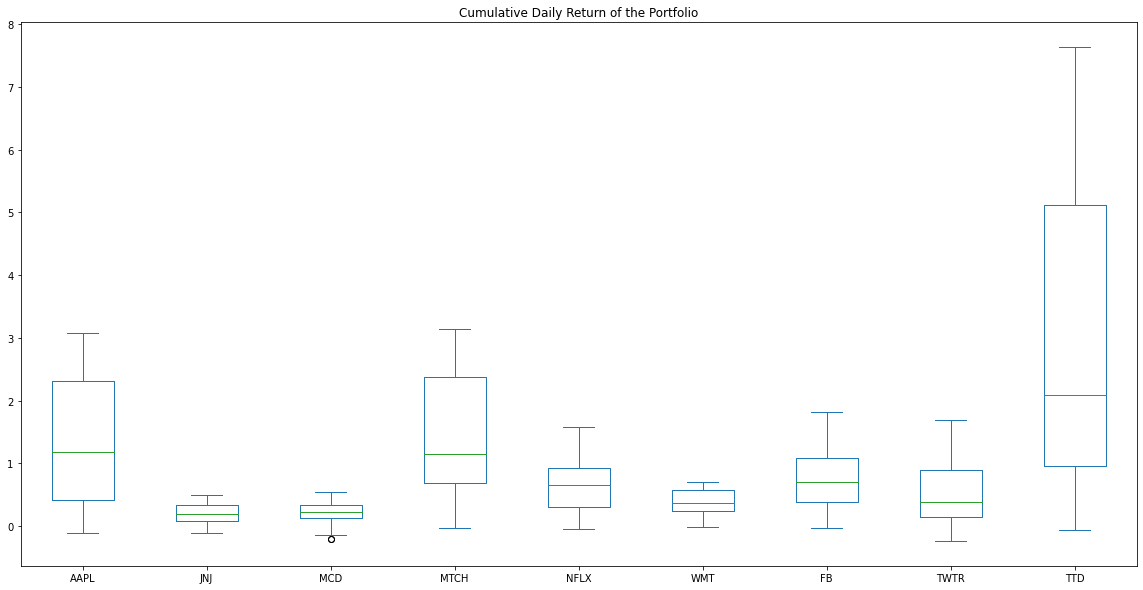

In [39]:
cum_daily_returns_df.plot(figsize=(20,10),kind='box' ,title="Cumulative Daily Return of the Portfolio")

# Standard Deviation

In [40]:
df_daily_returns_dev= df_daily_returns.std()
df_daily_returns_dev.sort_values(ascending=True)
df_daily_returns_dev

AAPL    0.021638
JNJ     0.013712
MCD     0.016763
MTCH    0.030479
NFLX    0.024322
WMT     0.014023
FB      0.022379
TWTR    0.031887
TTD     0.044211
dtype: float64

## Annualized Standard Deviation

In [41]:
# Calculate and sort the annualized standard deviation (252 trading days) of the portfolio
# Review the annual standard deviations smallest to largest
df_daily_returns_dev_252 = df_daily_returns_dev*np.sqrt(252)
df_daily_returns_dev_252.sort_values(ascending=True)

JNJ     0.217674
WMT     0.222613
MCD     0.266110
AAPL    0.343500
FB      0.355255
NFLX    0.386105
MTCH    0.483843
TWTR    0.506186
TTD     0.701835
dtype: float64

## Rolling 21 Day Daily Return of the Portfolio

<AxesSubplot:title={'center':'Rolling 21 Day Daily Return of the Portfolio'}, xlabel='Date'>

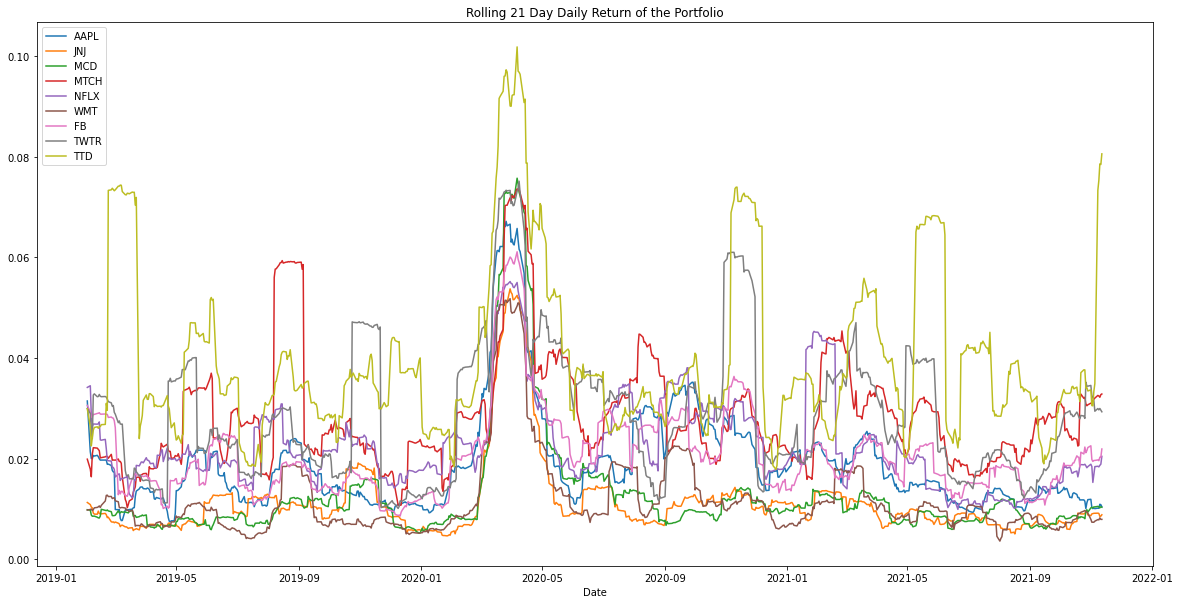

In [42]:
df_daily_returns_std_21=df_daily_returns.rolling(window=21).std()
df_daily_returns_std_21.dropna(inplace=True)
df_daily_returns_std_21.plot(figsize=(20,10),title="Rolling 21 Day Daily Return of the Portfolio")

## Annualized Daily returns

In [43]:
# Calculate the annualized Returns
df_annual_returns=df_daily_returns.mean()*252
df_annual_returns.sort_values(ascending=True)

JNJ     0.138312
MCD     0.181379
WMT     0.201526
TWTR    0.338402
FB      0.384383
NFLX    0.400566
AAPL    0.535058
MTCH    0.547893
TTD     0.995350
dtype: float64

## Sharpe Ratio : 
The Sharpe Ratio is a financial metric often used by investors when assessing the performance of investment management products and professionals. It consists of taking the excess return of the portfolio, relative to the risk-free rate, and dividing it by the standard deviation of the portfolio's excess returns. Conceptually, what this provides is a measurement of the portfolio's outperformance per unit of the portfolio's volatility. All else being equal, portfolios with higher excess returns or lower volatility will show higher Sharpe Ratios, and vice-versa.
<br/>
Usually, any Sharpe ratio greater than 1.0 is considered acceptable to good by investors. A ratio higher than 2.0 is rated as very good. A ratio of 3.0 or higher is considered excellent. A ratio under 1.0 is considered sub-optimal.


In [44]:
# Calculate the annualized Sharpe Ratios for each of the portfolio
# Review the Sharpe ratios sorted lowest to highest
df_sharpe=df_annual_returns/df_daily_returns_dev_252
df_sharpe.sort_values(ascending=True)

JNJ     0.635407
TWTR    0.668533
MCD     0.681595
WMT     0.905273
NFLX    1.037454
FB      1.081992
MTCH    1.132379
TTD     1.418210
AAPL    1.557663
dtype: float64

<AxesSubplot:title={'center':'Sharpe ratios for the portfolio'}>

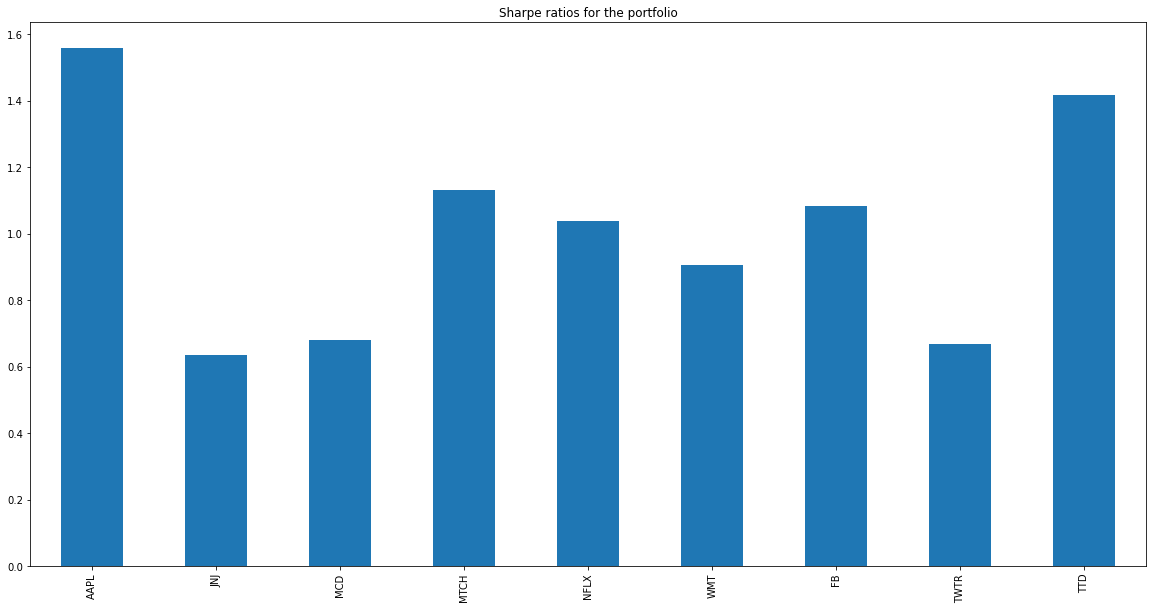

In [45]:
# Visualize the Sharpe ratios as a bar chart
df_sharpe.plot(kind='bar', figsize=(20,10), title='Sharpe ratios for the portfolio')

# Covariance Calculation
If a portfolio has multiple assets, its volatility is calculated using a matrix. A variance-covariance matrix is computed for all the assets. The vector of the weights of the assets in the portfolio is multiplied by the transpose of the vector of the weights of the assets multiplied by the covariance matrix of all of the assets.



In [46]:
# Calculate the variance of the SPY using a rolling 60-day window.
df_spy_daily_returns = df_closing_prices['^GSPC'].pct_change()
df_spy_var=df_spy_daily_returns.rolling(window=60).var()
df_spy_var

Date
2019-01-02         NaN
2019-01-03         NaN
2019-01-04         NaN
2019-01-07         NaN
2019-01-08         NaN
                ...   
2021-11-08    0.000052
2021-11-09    0.000052
2021-11-10    0.000052
2021-11-11    0.000050
2021-11-12    0.000051
Name: ^GSPC, Length: 724, dtype: float64

In [47]:
#Calculate Rolling Covariance 60 day

rolling_covariance_60day = df_daily_returns.rolling(window=60).cov(df_spy_daily_returns)

rolling_covariance_60day.tail()

# get the weights of the stocks in the portfolio using CostBasis
weight_df = portfolio_df
for ticker in portfolio_tickers:
    weight_df = portfolio_df['Cost Basis']/portfolio_df['Cost Basis'].sum()

rolling_covariance_portfolio_60day = rolling_covariance_60day.dot(weight_df.to_list())

rolling_covariance_portfolio_60day

Date
2019-01-02         NaN
2019-01-03         NaN
2019-01-04         NaN
2019-01-07         NaN
2019-01-08         NaN
                ...   
2021-11-08    0.000046
2021-11-09    0.000046
2021-11-10    0.000047
2021-11-11    0.000046
2021-11-12    0.000047
Length: 724, dtype: float64

### Beta Calculation
Beta is a measure of a stock's volatility in relation to the overall market. ... If a stock moves less than the market, the stock's beta is less than 1.0. High-beta stocks are supposed to be riskier but provide higher return potential; low-beta stocks pose less risk but also lower returns.

#### Portfolio Beta
The beta of a portfolio is the weighted sum of the individual asset betas, According to the proportions of the investments in the portfolio. E.g., if 50% of the money is in stock A with a beta of 2.00, and 50% of the money is in stock B with a beta of 1.00,the portfolio beta is 1.50.


In [48]:
# Calculate the beta based on the 60-day rolling covariance compared to the market (S&P 500)
# Review the last five rows of the beta information
rolling_portfolio_beta=rolling_covariance_portfolio_60day/df_spy_var
rolling_portfolio_beta.tail()

Date
2021-11-08    0.893017
2021-11-09    0.886536
2021-11-10    0.898408
2021-11-11    0.913061
2021-11-12    0.934101
dtype: float64

In [49]:
# Calculate the average of the 60-day rolling beta
avg_rolling_portfolio_beta = rolling_portfolio_beta.mean()
avg_rolling_portfolio_beta

0.9510481890514232

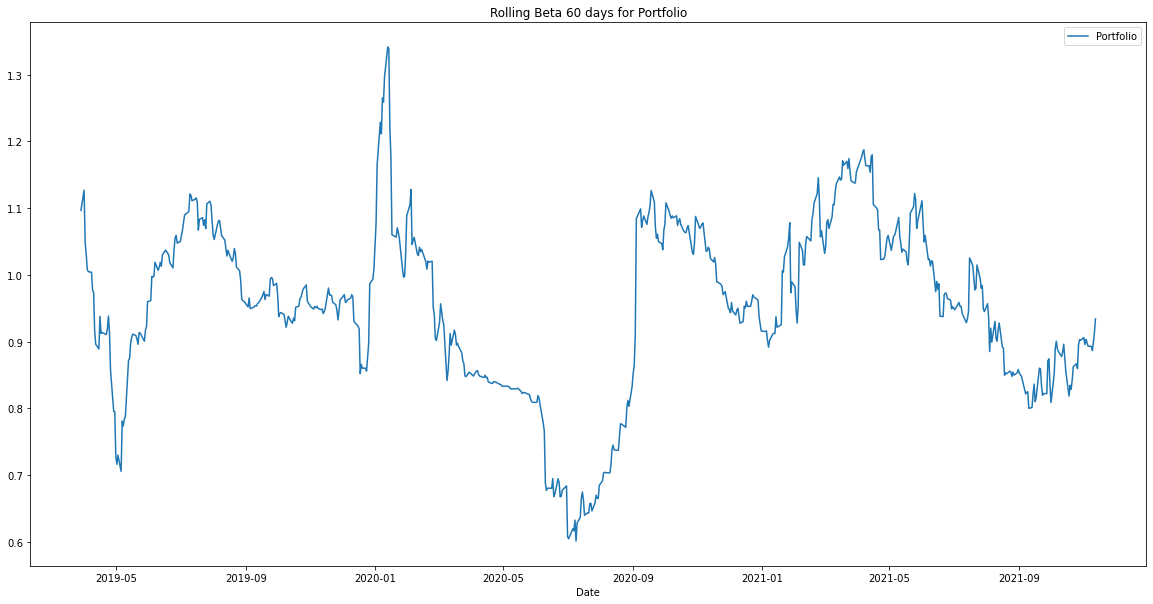

In [50]:
# Plot the rolling beta 
# Include a title parameter and adjust the figure size
ax = rolling_portfolio_beta.plot(figsize=(20,10), title='Rolling Beta 60 days for Portfolio')
ax.legend(["Portfolio"])

In [51]:
df_ticker.head()

Adj Close                                                 \
                 AAPL          FB         JNJ         MCD       MTCH   
Date                                                                   
2019-01-02  38.326290  135.679993  118.758545  164.881226  42.380001   
2019-01-03  34.508713  131.740005  116.871414  163.794846  41.119999   
2019-01-04  35.981861  137.949997  118.832909  166.960251  43.049999   
2019-01-07  35.901779  138.050003  118.070633  168.777084  43.369999   
2019-01-08  36.586170  142.529999  120.813011  169.132950  44.779999   

                                                                   ...  \
                  NFLX     TTD       TWTR        WMT        ^GSPC  ...   
Date                                                               ...   
2019-01-02  267.660004  11.616  28.809999  88.933044  2510.030029  ...   
2019-01-03  271.200012  10.956  27.990000  88.475731  2447.889893  ...   
2019-01-04  297.570007  11.792  29.950001  89.028336  2531.939941  ...   
2019-01-07  315.339996  12.457  31.340000  90.076393  2549.689941  ...   
2019-01-08  320.269989  12.805  31.799999  90.705238  2574.409912  ...   

               Volume                                                 \
                 AAPL        FB      JNJ      MCD     MTCH      NFLX   
Date                                                                   
2019-01-02  148158800  28146200  7631700  2571500  1677800  11679500   
2019-01-03  365248800  22717900  8654500  3728200  1828000  14969600   
2019-01-04  234428400  29002100  8831700  3194300  2460100  19330100   
2019-01-07  219111200  20089300  8404700  3283000  1471900  18620100   
2019-01-08  164101200  26263800  9351600  2941400  2470500  15359200   

                                                     
                 TTD      TWTR      WMT       ^GSPC  
Date                                                 
2019-01-02   8393000  15053700  8152700  3733160000  
2019-01-03   7754000  19051700  8277300  3822860000  
2019-01-04  11460000  23412600  8029100  4213410000  
2019-01-07  10790000  19917800  7789700  4104710000  
2019-01-08   9501000  18915200  7200900  4083030000  

[5 rows x 60 columns]

In [52]:
# Get the Portfolio without the S&P 500 numbers
df_portfolio_ticker = df_ticker
df_portfolio_ticker.columns = df_portfolio_ticker.columns.swaplevel(0, 1)
df_portfolio_ticker.sort_index(axis=1, level=0, inplace=True)
df_portfolio_ticker = df_portfolio_ticker.drop(columns='^GSPC')
df_portfolio_ticker = df_portfolio_ticker.rename(columns={'Adj Close':'close'})


In [53]:
#verify the sum of the weights
weight_df.sum()

1.0

### MonteCarlo Simulation
* The Monte Carlo method uses a random sampling of information to solve a statistical problem; while a simulation is a way to virtually demonstrate a strategy.
* Combined, the Monte Carlo simulation enables a user to come up with a bevy of results for a statistical problem with numerous data points sampled repeatedly.
* The Monte Carlo simulation can be used in corporate finance, options pricing, and especially portfolio management and personal finance planning. 
* On the downside, the simulation is limited in that it can't account for bear markets, recessions, or any other kind of financial crisis that might impact potential results.

In [54]:
# Set number of simulations
num_sims = 1000

# Configure a Monte Carlo simulation to forecast three years daily returns
MC_Portfolio = MCSimulation(
    portfolio_data = df_portfolio_ticker,
    #weights=[0.20, 0.20, 0.40, 0.20],
    weights=weight_df.to_list(),
    num_simulation = num_sims,
    num_trading_days = 252*3
)

In [55]:
#Run the Simulation
MC_Portfolio.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/patrickbeeson/Desktop/bootcamp-project-1/MCForecastTools.py:117: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000136,1.014943,0.980811,1.004375,1.013554,1.010604,1.001631,0.993289,1.007909,1.014818,...,1.017062,1.000347,0.998265,0.982405,1.018131,1.009618,0.992548,1.009164,1.002539,0.984733
2,0.979508,1.022256,0.982069,1.006801,1.025546,1.001623,1.000786,1.000480,1.002342,1.018848,...,1.022366,0.995045,1.011688,0.976408,1.021075,1.017299,0.958019,1.018853,0.993367,0.991982
3,0.970109,1.019137,0.986061,1.017988,1.035859,1.001246,0.996348,0.999216,0.999640,1.011352,...,1.020491,0.988425,1.002657,0.972134,1.014995,1.009400,0.962553,1.009570,0.982997,0.983081
4,0.975701,1.020322,0.982195,1.004049,1.026279,1.004035,0.994052,1.008868,0.992944,1.012316,...,1.022750,0.982986,0.999368,0.978257,1.040513,1.016204,0.972692,1.002256,0.993876,0.969108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
752,3.966631,4.108057,4.171797,7.680033,5.378004,4.802769,5.375083,4.797912,3.994861,4.398294,...,3.380636,2.938351,8.137613,3.897630,6.480619,4.174200,4.657068,2.395630,6.760844,5.132701
753,3.970032,4.183989,4.171866,7.668250,5.341924,4.800611,5.429049,4.877460,4.039843,4.413604,...,3.372166,2.925164,8.143085,3.927682,6.373596,4.156241,4.729298,2.395779,6.672871,5.140620
754,3.900333,4.168530,4.173241,7.667447,5.406310,4.825640,5.411826,4.818348,4.036003,4.414665,...,3.455094,2.903119,8.220272,3.924081,6.502500,4.146713,4.735841,2.364169,6.642403,5.116845
755,3.881709,4.153195,4.220174,7.785675,5.382770,4.770005,5.432456,4.847188,4.079128,4.444569,...,3.422244,2.976396,8.258033,3.920603,6.439117,4.130237,4.735236,2.387467,6.683334,5.198028


<AxesSubplot:title={'center':'1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 756 Trading Days.'}>

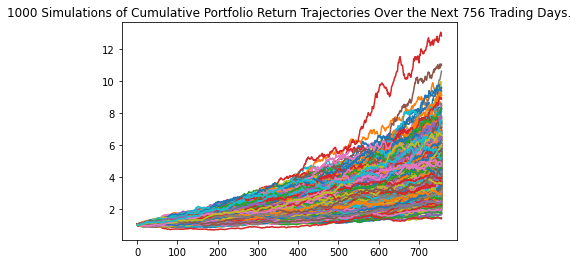

In [56]:
MC_Portfolio.plot_simulation()

In [57]:
#Compute the Simulated Returns
simulated_returns_data = {
    "mean": list(MC_Portfolio.simulated_return.mean(axis=1)),
    "median": list(MC_Portfolio.simulated_return.median(axis=1)),
    "min": list(MC_Portfolio.simulated_return.min(axis=1)),
    "max": list(MC_Portfolio.simulated_return.max(axis=1))
}

# Create a DataFrame with the summary statistics
df_simulated_returns = pd.DataFrame(simulated_returns_data)

# Display sample data
df_simulated_returns.head()

,mean,median,min,max
0,1.000000,1.000000,1.000000,1.000000
1,1.001935,1.001880,0.965117,1.045175
2,1.003911,1.004261,0.948763,1.061692
3,1.005777,1.005802,0.941267,1.074109
4,1.008030,1.007573,0.940974,1.087104


In [58]:
#Display the Simulated Returns
df_simulated_data=MC_Portfolio.simulated_return
df_simulated_data.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000136,1.014943,0.980811,1.004375,1.013554,1.010604,1.001631,0.993289,1.007909,1.014818,...,1.017062,1.000347,0.998265,0.982405,1.018131,1.009618,0.992548,1.009164,1.002539,0.984733
2,0.979508,1.022256,0.982069,1.006801,1.025546,1.001623,1.000786,1.000480,1.002342,1.018848,...,1.022366,0.995045,1.011688,0.976408,1.021075,1.017299,0.958019,1.018853,0.993367,0.991982
3,0.970109,1.019137,0.986061,1.017988,1.035859,1.001246,0.996348,0.999216,0.999640,1.011352,...,1.020491,0.988425,1.002657,0.972134,1.014995,1.009400,0.962553,1.009570,0.982997,0.983081
4,0.975701,1.020322,0.982195,1.004049,1.026279,1.004035,0.994052,1.008868,0.992944,1.012316,...,1.022750,0.982986,0.999368,0.978257,1.040513,1.016204,0.972692,1.002256,0.993876,0.969108


#### Compute the Cumulative P&L

In [59]:
# Set initial investment to the Current Value
initial_investment = merged_portfolio_sp_YTD['Current Value'].sum()

# Multiply an initial investment by the daily returns of simulative stock prices to return the progression of daily returns in terms of money
cumulative_pnl = initial_investment * df_simulated_returns

# Display sample data
cumulative_pnl.head()

,mean,median,min,max
0,258543.500900,258543.500900,258543.500900,258543.500900
1,259043.873670,259029.547017,249524.668920,270223.259175
2,259554.673259,259645.149569,245296.508204,274493.509966
3,260037.019363,260043.502747,243358.585645,277703.895029
4,260619.528165,260501.505570,243282.632961,281063.633663


<AxesSubplot:title={'center':'Simulated Outcomes Behavior of the Portfolio Over the Next 3 Years'}>

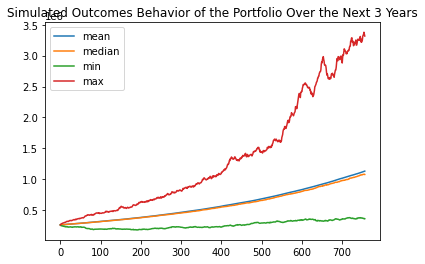

In [60]:
# Plot the Cumulative P&L
cumulative_pnl.plot(title="Simulated Outcomes Behavior of the Portfolio Over the Next 3 Years")

In [61]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_Portfolio.summarize_cumulative_return()

# Print summary statistics
print(tbl)

count           1000.000000
mean               4.368850
std                1.464745
min                1.386164
25%                3.299888
50%                4.161377
75%                5.202272
max               12.832123
95% CI Lower       2.134193
95% CI Upper       7.647196
Name: 756, dtype: float64


In [62]:
# Compute the upper bound and lower bound with 95% confidence
ci_lower = round(tbl[8]*initial_investment,2)
ci_upper = round(tbl[9]*initial_investment,2)
print(f"There is a 95% chance that a current investment of ${initial_investment:,.2f} in the portfolio"
      f" over the next year will end within in the range of"
      f" ${ci_lower:,.2f} and ${ci_upper:,.2f}.")

There is a 95% chance that a current investment of $258,543.50 in the portfolio over the next year will end within in the range of $551,781.62 and $1,977,132.71.


In [63]:
#display the merged portfolio
merged_portfolio_sp_YTD

,Acquisition Date,Quantity,Unit Cost,Cost Basis,Start of Year,Last Close,Ticker Return,SPY Closes,Equiv SPY Shares,SPY Latest Close,...,YTD Close,SPY YTD Close,Share YTD,SPY YTD,Cum Invst,Cum Ticker Returns,Cum SP Returns,Cum Ticker ROI Mult,Current Value,Pct Change
Ticker,,,,,,,,,,,,,,,,,,,,,
AAPL,2019-02-07,300,43.50,13050.00,2020-12-31,149.990005,2.448046,2706.050049,4.822527,4682.850098,...,131.876999,3756.070068,0.137348,0.246742,13050.00,44997.001648,22583.172030,3.448046,44997.001648,3.448046
JNJ,2019-02-07,100,132.50,13250.00,2020-12-31,165.009995,0.245358,2706.050049,4.896436,4682.850098,...,154.516754,3756.070068,0.067910,0.246742,26300.00,61498.001099,45512.446313,2.338327,16500.999451,1.245358
MCD,2019-02-07,100,175.20,17520.00,2020-12-31,250.669998,0.430765,2706.050049,6.474381,4682.850098,...,210.939972,3756.070068,0.188348,0.246742,43820.00,86565.000916,75831.003705,1.975468,25066.999817,1.430765
MTCH,2019-02-07,200,55.80,11160.00,2020-12-31,146.949997,1.633512,2706.050049,4.124092,4682.850098,...,151.190002,3756.070068,-0.028044,0.246742,54980.00,115955.000305,95143.509441,2.109040,29389.999390,2.633512
NFLX,2019-02-07,75,345.40,25905.00,2020-12-31,682.609985,0.976288,2706.050049,9.572994,4682.850098,...,540.729980,3756.070068,0.262386,0.246742,80885.00,167150.749207,139972.403804,2.066523,51195.748901,1.976288
WMT,2019-02-07,125,149.35,18668.75,2020-12-31,147.759995,-0.010646,2706.050049,6.898893,4682.850098,...,142.464844,3756.070068,0.037168,0.246742,99553.75,185620.748520,172278.886014,1.864528,18469.999313,0.989354
FB,2019-02-07,150,165.50,24825.00,2020-12-31,340.890015,1.059758,2706.050049,9.173888,4682.850098,...,273.160004,3756.070068,0.247950,0.246742,124378.75,236754.250717,215238.828209,1.903494,51133.502197,2.059758
TWTR,2019-02-07,225,30.31,6819.75,2020-12-31,52.250000,0.723854,2706.050049,2.520186,4682.850098,...,54.150002,3756.070068,-0.035088,0.246742,131198.50,248510.500717,227040.482420,1.894157,11756.250000,1.723854
TTD,2019-02-07,100,14.30,1430.00,2020-12-31,100.330002,6.016084,2706.050049,0.528446,4682.850098,...,80.099998,3756.070068,0.252559,0.246742,132628.50,258543.500900,229515.113531,1.949381,10033.000183,7.016084


#### Prep work to Display the Charts and Tables

In [64]:
merged_portfolio_sp_YTD.reset_index(inplace=True)

In [65]:
merged_portfolio_sp_YTD.dtypes

Ticker                         object
Acquisition Date       datetime64[ns]
Quantity                        int64
Unit Cost                     float64
Cost Basis                    float64
Start of Year          datetime64[ns]
Last Close                    float64
Ticker Return                 float64
SPY Closes                    float64
Equiv SPY Shares              float64
SPY Latest Close              float64
SP Return                     float64
Abs. Return Compare           float64
Ticker Share Value            float64
SPY Value                     float64
Abs Value Compare             float64
Stock Gain / (Loss)           float64
SPY Gain / (Loss)             float64
YTD Close                     float64
SPY YTD Close                 float64
Share YTD                     float64
SPY YTD                       float64
Cum Invst                     float64
Cum Ticker Returns            float64
Cum SP Returns                float64
Cum Ticker ROI Mult           float64
Current Valu

In [66]:
df=merged_portfolio_sp_YTD
#df = df.rename(columns={'Current Value':'Current_Value', 'Stock Gain / (Loss)': 'Stock_Gain_Loss'})
#df['Current_Value'] = df['Current_Value'].map("\$:,.2f".format)
#df['Stock_Gain_Loss'] = df['Stock_Gain_Loss'].map("\$:,.2f".format)
#df['Current_Value']

df = df[['Ticker','Cost Basis','Current Value','Stock Gain / (Loss)','Pct Change']]
#df = df.set_index('Ticker')
df

,Ticker,Cost Basis,Current Value,Stock Gain / (Loss),Pct Change
0,AAPL,13050.00,44997.001648,31947.001648,3.448046
1,JNJ,13250.00,16500.999451,3250.999451,1.245358
2,MCD,17520.00,25066.999817,7546.999817,1.430765
3,MTCH,11160.00,29389.999390,18229.999390,2.633512
4,NFLX,25905.00,51195.748901,25290.748901,1.976288
5,WMT,18668.75,18469.999313,-198.750687,0.989354
6,FB,24825.00,51133.502197,26308.502197,2.059758
7,TWTR,6819.75,11756.250000,4936.500000,1.723854
8,TTD,1430.00,10033.000183,8603.000183,7.016084


In [67]:
#Sum up by Row totals
df_portfolio_value.loc[:,'Total'] = df_portfolio_value.sum(axis=1)
# this ends up skewing the chart
df_portfolio_value


Ticker,AAPL,JNJ,MCD,MTCH,NFLX,WMT,FB,TWTR,TTD,Total
Date,,,,,,,,,,
2019-01-02,11497.887039,11875.854492,16488.122559,8476.000214,20074.500275,11116.630554,20351.998901,6482.249880,1161.600018,107524.843931
2019-01-03,10352.613831,11687.141418,16379.484558,8223.999786,20340.000916,11059.466362,19761.000824,6297.749949,1095.600033,105197.057676
2019-01-04,10794.558334,11883.290863,16696.025085,8609.999847,22317.750549,11128.541946,20692.499542,6738.750172,1179.199982,110040.616322
2019-01-07,10770.533752,11807.063293,16877.708435,8673.999786,23650.499725,11259.549141,20707.500458,7051.500034,1245.699978,112044.054604
2019-01-08,10975.851059,12081.301117,16913.294983,8955.999756,24020.249176,11338.154793,21379.499817,7154.999828,1280.500031,114099.850559
...,...,...,...,...,...,...,...,...,...,...
2021-11-08,45132.000732,16286.999512,25310.000610,31182.000732,48858.750916,18658.750534,50792.999268,12168.000412,8875.000000,257264.502716
2021-11-09,45242.999268,16250.999451,25264.999390,31117.999268,49199.249268,18723.749161,50305.499268,12082.500172,9708.999634,257896.994877
2021-11-10,44375.999451,16427.000427,25313.000488,30810.000610,48518.247986,18555.000305,49146.002197,11774.250412,8866.000366,253785.502243


<AxesSubplot:title={'center':'Portfolio Value'}, xlabel='Date'>

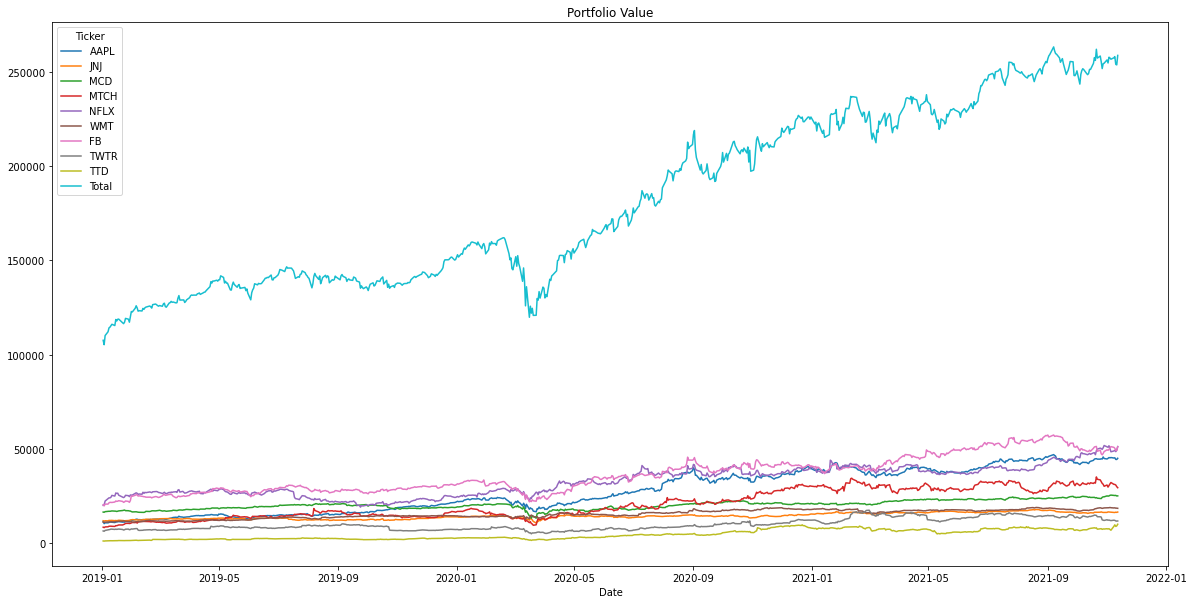

In [68]:
df_portfolio_value.plot(figsize=(20,10), title='Portfolio Value')

## Display of Various Charts, Tables, Calculations

In [69]:
fig_current_pnlvalue = px.pie(merged_portfolio_sp_YTD, 
                           values='Stock Gain / (Loss)', names='Ticker', 
                           title='<b>Portfolio Current P&L</b>',height=400, width=800
                          )
fig_current_value = px.pie(merged_portfolio_sp_YTD, 
                           values='Current Value', names='Ticker', 
                           title='<b>Portfolio Current Value</b>',height=400, width=800
                          )

# YTD Charts

In [70]:
# Ploty is an outstanding resource for interactive charts.

trace1 = go.Bar(
    x = merged_portfolio_sp_YTD['Ticker'][0:10],
    y = merged_portfolio_sp_YTD['Share YTD'][0:10],
    name = 'Ticker YTD')

trace2 = go.Scatter(
    x = merged_portfolio_sp_YTD['Ticker'][0:10],
    y = merged_portfolio_sp_YTD['SPY YTD'][0:10],
    name = 'SPY YTD')
    
data1 = [trace1, trace2]

layout1 = go.Layout(title = '<b>YTD Return vs SPY YTD</b>'
    , barmode = 'group'
    , yaxis=dict(title='Returns', tickformat=".2%")
    , xaxis=dict(title='Ticker')
    , legend=dict(x=.8,y=1)
    ,height=800, width=1600
    )

fig1 = go.Figure(data=data1, layout=layout1)

# Total Return Comparison Charts

In [71]:
trace3 = go.Bar(
    x = merged_portfolio_sp_YTD['Ticker'][0:10],
    y = merged_portfolio_sp_YTD['Ticker Return'][0:10],
    name = 'Ticker Total Return')

trace4 = go.Scatter(
    x = merged_portfolio_sp_YTD['Ticker'][0:10],
    y = merged_portfolio_sp_YTD['SP Return'][0:10],
    name = 'SP500 Total Return')
    
data2 = [trace3, trace4]

layout2 = go.Layout(title = '<b>Total Return vs S&P 500</b>'
    , barmode = 'group'
    , yaxis=dict(title='Returns', tickformat=".2%")
    , xaxis=dict(title='Ticker', tickformat=".2%")
    , legend=dict(x=.8,y=1)
    ,height=800, width=1600
    )

fig2 = go.Figure(data=data2, layout=layout2)

## Gain / (Loss) Total Return vs SPY

# 

In [72]:
trace5 = go.Bar(
    x = merged_portfolio_sp_YTD['Ticker'][0:10],
    y = merged_portfolio_sp_YTD['Stock Gain / (Loss)'][0:10],
    name = 'Ticker Total Return ($)')

trace6 = go.Bar(
    x = merged_portfolio_sp_YTD['Ticker'][0:10],
    y = merged_portfolio_sp_YTD['SPY Gain / (Loss)'][0:10],
    name = 'SPY Total Return ($)')

trace7 = go.Scatter(
    x = merged_portfolio_sp_YTD['Ticker'][0:10],
    y = merged_portfolio_sp_YTD['Ticker Return'][0:10],
    name = 'Ticker Total Return %',
    yaxis='y2')

data3 = [trace5, trace6, trace7]

layout3 = go.Layout(title = '<b>Gain / (Loss) Total Return vs SPY</b>'
    , barmode = 'group'
    , yaxis=dict(title='Gain / (Loss) ($)')
    , yaxis2=dict(title='Ticker Return', overlaying='y', side='right', tickformat=".2%")
    , xaxis=dict(title='Ticker')
    , legend=dict(x=.75,y=1)
    ,height=800, width=1600
    )

fig3 = go.Figure(data=data3, layout=layout3)

### Total Cumulative Investments Over time

In [73]:
trace8 = go.Bar(
    x = merged_portfolio_sp_YTD['Ticker'],
    y = merged_portfolio_sp_YTD['Cum Invst'],
    # mode = 'lines+markers',
    name = 'Cum Invst')

trace9 = go.Bar(
    x = merged_portfolio_sp_YTD['Ticker'],
    y = merged_portfolio_sp_YTD['Cum SP Returns'],
    # mode = 'lines+markers',
    name = 'Cum SP500 Returns')

trace10 = go.Bar(
    x = merged_portfolio_sp_YTD['Ticker'],
    y = merged_portfolio_sp_YTD['Cum Ticker Returns'],
    # mode = 'lines+markers',
    name = 'Cum Ticker Returns')

trace11 = go.Scatter(
    x = merged_portfolio_sp_YTD['Ticker'],
    y = merged_portfolio_sp_YTD['Cum Ticker ROI Mult'],
    # mode = 'lines+markers',
    name = 'Cum ROI Mult'
    , yaxis='y2')


data4 = [trace8, trace9, trace10, trace11]

layout4 = go.Layout(title = '<b>Total Cumulative Investments Over Time</b>'
    , barmode = 'group'
    , yaxis=dict(title='Returns')
    , xaxis=dict(title='Ticker')
    , legend=dict(x=.4,y=1)
    , yaxis2=dict(title='Cum ROI Mult', overlaying='y', side='right')  
    ,height=800, width=1600
    )

fig4 = go.Figure(data=data4, layout=layout4)

### Method to have per symbol selection for charts

In [74]:
def multi_plot(df, chartTitle, label, addAll = True):
   
    
    fig = go.Figure(layout=go.Layout(height=800, width=1600))
    
    
    for column in df.columns.to_list():
        if column != 'Total':
            fig.add_trace(
                go.Scatter(
                    x = df.index,
                    y = df[column],
                    name = column
                 )
            )
        elif column == 'Total':
            fig.add_trace(
            go.Scatter(
                x = df.index,
                y = df[column],
                name = column,
                visible='legendonly'

                ) 
            )
    
    
    button_all = dict(label = 'All',
                      method = 'update',
                      args = [{'visible': df.columns.isin(df.columns),
                               'title': 'All',
                               'showlegend':True}])

    def create_layout_button(column):
        return dict(label = column,
                    method = 'update',
                    args = [{'visible': df.columns.isin([column]),
                             'title': column,
                             'showlegend': True}])

    fig.update_layout(
        updatemenus=[go.layout.Updatemenu(
            active = 1,
            buttons = ([button_all] * addAll) + 
                list(df.columns.map(lambda column: create_layout_button(column)))
            
            )
            
            
        ],title_text=chartTitle)
    return fig


### Charts for Daily Returns, Cumulative Returns, Rolling 21 Day Returns, Rolling 60 Day Beta for the Portfolio and Simulated Returns

In [75]:
fig5 = multi_plot(df_daily_returns,'<b>Daily Returns</b>',"Daily Returns")

In [76]:
fig6 = px.box(cum_daily_returns_df, title = '<b>Cumulative  Returns</b>'
              ,height=800, width=1600
        )

In [77]:
fig7 = multi_plot(df_daily_returns_std_21, '<b>Rolling 21 Day Returns</b>',"21 Day Returns")

In [78]:
fig8= px.bar(df_sharpe,title='<b>Sharpe Ratio</b>',
                      labels={"value": "Sharpe Ratio"}
                      #,template='simple_white'
                      ,height=800, width=1600
                     )

In [79]:
fig9 = px.line(rolling_portfolio_beta,title='<b>Rolling 60 Day Beta of the Portfolio</b>',
                      labels={"value": "Beta"}
                      #,template='simple_white'
                      ,height=800, width=1600
                     )

In [80]:
fig_portfolio_value = multi_plot(df_portfolio_value,'<b>Portfolio Value<b>', 'Portfolio Value')

In [81]:
fig_simulated_returns = px.line(df_simulated_data, 
                          title='<b>Simulated Returns of the Portfolio</b>',
                          labels={"value": "Returns"}
                          ,height=800, width=1600
                         )

/Users/patrickbeeson/opt/anaconda3/envs/sqlenv/lib/python3.7/site-packages/plotly/express/_core.py:1222: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



In [82]:
fig_simulated_cum_pnl = px.line(cumulative_pnl, 
                          title='<b>Simulated Cumulative P&L<b>',
                          labels={"value": "Returns"}
                          ,height=800, width=1600
                         )

## Display in Dash/Plotly
All charts and tables are displayed in plotly. Plotly creates a local web server to view the results

In [84]:
app = dash.Dash()

app.layout = html.Div( children=[
    html.Div([
        html.H1(children='Portfolio Analysis Dashboard',style={
                'textAlign': 'center','align': 'center'})
    ])
    ,html.Hr()
    ,html.Div(
            dash_table.DataTable(
                id="Portfolio Summary Table",
                columns=[
                    {"name": "Ticker", "id": "Ticker"},
                    {
                        "name": "Cost Basis",
                        "id": "Cost Basis",
                        "type": "numeric",
                        "format": Format()  # formatted using the Format() object
                        .scheme(Scheme.fixed)
                        .precision(2)
                        .symbol_prefix("$")
                        .symbol(Symbol.yes)
                        .group(Group.yes),
                    },
                   {
                        "name": "Current Value",
                        "id": "Current Value",
                        "type": "numeric",
                        # formatted using FormatTemplate:
                        "format": FormatTemplate.money(2),
                    },
                    {
                        "name": "Stock Gain / (Loss)",
                        "id": "Stock Gain / (Loss)",
                        "type": "numeric",
                        # formatted using FormatTemplate:
                        "format": FormatTemplate.money(2),
                    },
                    {
                        "name": "% Change",
                        "id": "Pct Change",
                        "type": "numeric",
                        # formatted using FormatTemplate:
                        "format": FormatTemplate.percentage(2),
                    },
                ]
                ,data=df.to_dict("records")
                ,fixed_rows={'headers': True}
                ,style_table={'maxHeight': '50ex','overflowY': 'scroll','width': '100%','minWidth': '100%',} 
                ,style_cell={'minWidth': 80, 'maxWidth': 250, 'width': 250,
                             'font_family': 'sans-serif','font_size': '20px','text_align': 'center'}
                ,style_data={'whiteSpace': 'normal','height': 'auto'}
                ,fill_width=False
                
            )
        )
     
    ,html.Div([
        html.Div([ 
                    dcc.Graph(id="Portfolio Summary", figure=fig_current_value)], 
                style={'width': '48%', 'display': 'inline-block'})

        ,html.Div([
                    dcc.Graph(id="Portfolio PNL Summary", figure=fig_current_pnlvalue)],
                style={'width': '48%', 'align': 'right', 'display': 'inline-block'})
    ])
    #,dcc.Graph(id="Portfolio Summary", figure=fig_current_value)
    #,dcc.Graph(id="Portfolio PNL Summary", figure=fig_current_pnlvalue)
    ,html.Div([ dcc.Graph(id="Portfolio Value", figure=fig_portfolio_value)])
    
    ,html.Div([ dcc.Graph(id="Daily Returns", figure=fig5)])
    
    
    ,html.Div([dcc.Graph(id="Cumulative Returns", figure=fig6)])
    
   
    ,html.Div([dcc.Graph(id="Rolling 21 Day Returns", figure=fig7)])
    ,dcc.Graph(id="Sharpe Ratio", figure=fig8)
    

    ,html.Div([dcc.Graph(id="Rolling 60 Day Beta", figure=fig9)])
    ,html.H3(children=f"Average 60 Day Rolling Portfolio Beta is {avg_rolling_portfolio_beta:.2f}"
             )
    
    ,html.Div([dcc.Graph(id="Simulated Returns", figure=fig_simulated_returns)])
    
    ,html.Div([dcc.Graph(id="Simulated Cumulative P&L", figure=fig_simulated_cum_pnl)])
    ,html.H3(children=
        f"Summary: "
        f"There is a 95% chance that a current investment of ${initial_investment:,.2f} in the portfolio"
        f" over the next three years will end within in the range of"
        f" ${ci_lower:,.2f} and ${ci_upper:,.2f}."
    )
    
    ,html.Div([dcc.Graph(id="YTD Summary", figure=fig1)])
    ,html.Div([dcc.Graph(id="Total Return", figure=fig2)])
    

    ,html.Div([dcc.Graph(id="Total Cumulative Return", figure=fig3)])
    ,html.Div([dcc.Graph(id="Total Cumulative ROI", figure=fig4)])
    
    #,dcc.Graph(id="YOY Summary", figure=fig_year_summary)
    ##,dcc.Graph(id="Daily Volume", figure=fig_vol)
    #,dcc.Graph(id="Daily Returns", figure=fig_returns)
    #,dcc.Graph(id="Cumulative Daily Returns", figure=fig_cum_returns)
    #,dcc.Graph(id="Cumulative BTC Daily Returns", figure=fig_cum_btc_returns)
    #,dcc.Graph(id="Rolling 21 Day Daily Returns", figure=fig_daily_returns_std_21)
    #,dcc.Graph(id="Sharpe Ratio", figure=fig_sharpe_ratio)
    
    ##,dcc.Graph(id="Daily Returns and Volume", figure=fig)
])

app.css.append_css({
    'external_url': 'https://codepen.io/chriddyp/pen/bWLwgP.css'
})



#rendered = render_template('pdf_template.html')
#pdf = pdfkit.from_string(rendered, False)
#response = make_response(pdf)
#response.headers['Content-Type'] = 'application/pdf'
#response.headers['Content-Disposition'] = 'attachment; filename=output.pdf'


if __name__ == "__main__":
    #app.run_server(debug=True)
    app.run_server( port = 8096, dev_tools_ui=True, #debug=True,
              dev_tools_hot_reload =True, threaded=True)




Dash is running on http://127.0.0.1:8096/

Dash is running on http://127.0.0.1:8096/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8096/ (Press CTRL+C to quit)
127.0.0.1 - - [14/Nov/2021 12:11:50] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [14/Nov/2021 12:11:51] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [14/Nov/2021 12:11:54] "GET /_reload-hash HTTP/1.1" 200 -
127.0.0.1 - - [14/Nov/2021 12:11:55] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [14/Nov/2021 12:12:02] "GET /_reload-hash HTTP/1.1" 200 -
127.0.0.1 - - [14/Nov/2021 12:12:05] "GET /_reload-hash HTTP/1.1" 200 -
127.0.0.1 - - [14/Nov/2021 12:12:08] "GET /_reload-hash HTTP/1.1" 200 -
127.0.0.1 - - [14/Nov/2021 12:12:11] "GET /_reload-hash HTTP/1.1" 200 -
